In [1]:
import pandas as pd
df = pd.read_csv('~/Desktop/Datasets/2020-Jan.csv', header = 'infer', 
                parse_dates = ['event_time'], 
                 date_parser = pd.to_datetime, nrows=300000)

# RQ6

In [10]:
# Creating subsets

views = df[df.event_type == 'view']
purchases = df[df.event_type == 'purchase']

In [11]:
# Conversion rate = number of purchases / number of views

CR = purchases['product_id'].count() / views['product_id'].count()
print('The overall conversion rate is:', round(CR,3))

The overall conversion rate is: 0.098


### Categories method 1

In [12]:
# Finding categories

df['category_code'].unique()

array([nan, 'accessories.bag', 'stationery.cartrige',
       'appliances.environment.vacuum', 'apparel.glove',
       'appliances.personal.hair_cutter', 'furniture.living_room.cabinet',
       'accessories.cosmetic_bag', 'furniture.bathroom.bath',
       'appliances.environment.air_conditioner'], dtype=object)

The general categories are at the beginning of these strings (e.g. in `accessories.bag` we only need `accessories`), so we need to extract the category names

In [18]:
# Adjusting categories 

def fun(x):
    return str(x).split('.')[0]

df_categories["category"]=df_categories["category_code"].apply(fun)

In [19]:
df_categories['category'].unique()

array(['nan', 'accessories', 'stationery', 'appliances', 'apparel',
       'furniture'], dtype=object)

In [20]:
# Now we create again the subsets to include the new column ONLY NOT NAN

df_categories = df_categories[df_categories.category != 'nan']
views = df_categories[df_categories.event_type == 'view']
purchases = df_categories[df_categories.event_type == 'purchase']

In [24]:
df_categories['category'].unique()

array(['accessories', 'stationery', 'appliances', 'apparel', 'furniture'],
      dtype=object)

In [25]:
# Finding number of purchases for each category

d1 = purchases.groupby('category').event_type.count().reset_index().rename(columns =
                                                    {'event_type':'purchases_number'})
d1

,category,purchases_number
0,accessories,6
1,apparel,67
2,appliances,51
3,furniture,18
4,stationery,65


In [26]:
# Finding number of views for each category

d2 = views.groupby('category').event_type.count().reset_index().rename(columns =
                                                    {'event_type':'views_number'})

In [27]:
# Joining dataframes in order to have the number of purchases and views for each category

dout = d1.merge(d2, on = 'category')
dout

,category,purchases_number,views_number
0,accessories,6,347
1,apparel,67,320
2,appliances,51,1841
3,furniture,18,501
4,stationery,65,243


In [28]:
# Adding a third column that is a combination of the other two in order to find the c.r.

dout['conversion_rate'] = dout.apply(lambda row: 
                                     row.purchases_number / row.views_number, axis=1)

I'm assuming that the purchase rate is the number of purchases for each category. 

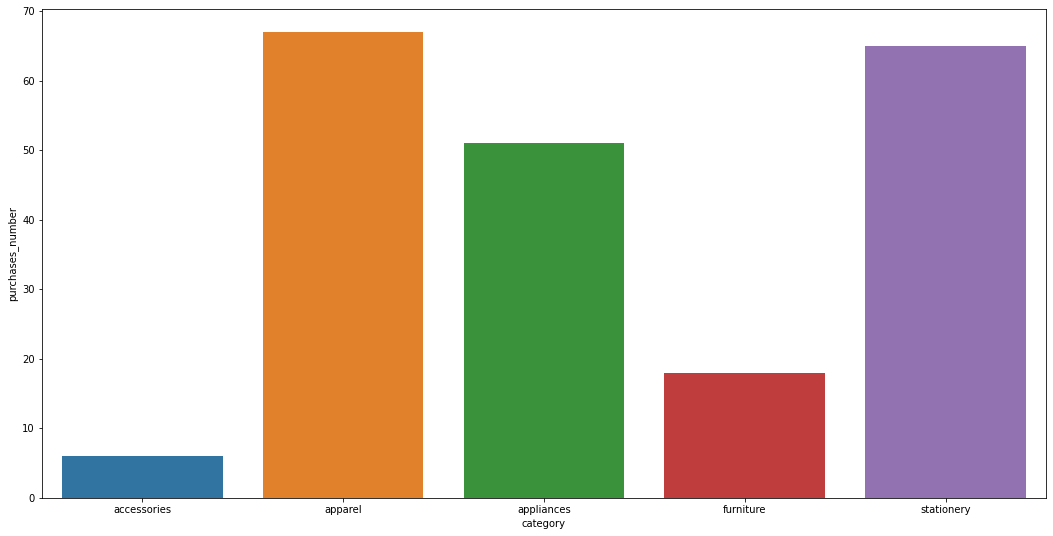

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,9))
plot = sns.barplot(x='category', y='purchases_number', data=dout)

In [25]:
# Sorting values

dout.sort_values(by='conversion_rate', ascending = False)

,category,purchases_number,views_number,conversion_rate
4,stationery,65,243,0.267490
1,apparel,67,320,0.209375
3,furniture,18,501,0.035928
2,appliances,51,1841,0.027702
0,accessories,6,347,0.017291


### Categories method 2

# RQ7

In [26]:
# Grouping customers and computing total revenue (amount of money spent) for each one 

customers = df.groupby('user_id').price.sum().to_frame('total_revenue').sort_values(
    by='total_revenue', ascending = False).reset_index()
customers

,user_id,total_revenue
0,373989853,136623.61
1,568233448,19152.54
2,523985247,6795.37
3,571953566,5764.92
4,595861471,5093.23
...,...,...
38921,595809918,0.00
38922,595471775,0.00
38923,595531690,0.00
38924,596496918,0.00


In [27]:
# Adding column with cumulative sum : cumul_sum[i] = cumul_sum[i-i] 

revenue = customers['total_revenue'].sum()
customers['cumul_sum'] = customers['total_revenue'].cumsum()
customers

,user_id,total_revenue,cumul_sum
0,373989853,136623.61,136623.61
1,568233448,19152.54,155776.15
2,523985247,6795.37,162571.52
3,571953566,5764.92,168336.44
4,595861471,5093.23,173429.67
...,...,...,...
38921,595809918,0.00,2864219.77
38922,595471775,0.00,2864219.77
38923,595531690,0.00,2864219.77
38924,596496918,0.00,2864219.77


In [30]:
# Adding column with the percentage of the cumulative sum over the store revenue 

customers['percent_cumul_sum'] = customers.apply(lambda row: 
                                     round(row.cumul_sum / revenue,4)*100, axis=1)
customers.head()

,user_id,total_revenue,cumul_sum,percent_cumul_sum
0,373989853,136623.61,136623.61,4.77
1,568233448,19152.54,155776.15,5.44
2,523985247,6795.37,162571.52,5.68
3,571953566,5764.92,168336.44,5.88
4,595861471,5093.23,173429.67,6.06


In [42]:
print('The', round((customers[customers['percent_cumul_sum'] >= 80].index[0]/len(customers)),3)*100,'percent of the users provides approximately the 80 percent of the store revenue.')

The 19.8 percent of the users provides approximately the 80 percent of the store revenue.


No handles with labels found to put in legend.


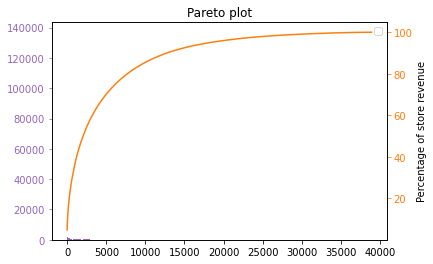

In [44]:
# DA AGGIUSTARE!

fig, ax = plt.subplots()
ax.bar(customers.index, customers["total_revenue"], color="C4")
ax2 = ax.twinx()
ax2.plot(customers.index, customers["percent_cumul_sum"], color="C1", ms=7)

plt.legend()
plt.title('Pareto plot')
plt.xlabel('Users')
plt.ylabel('Percentage of store revenue')
ax.tick_params(axis="y", colors="C4")
ax2.tick_params(axis="y", colors="C1")
plt.show()

# RQ1

#### Plot average operation

In [6]:
df['event_type'].unique()

array(['view', 'cart', 'remove_from_cart', 'purchase'], dtype=object)

In [14]:
event_series = df.groupby('event_type').event_type.count().to_frame('number_of_events').reset_index()
event_series

,event_type,number_of_events
0,cart,27024
1,purchase,4225
2,remove_from_cart,20339
3,view,48412


In [15]:
df[df.event_type=='view'].nunique()

event_time       37172
event_type           1
product_id       13783
category_id        389
category_code        9
brand              211
price             1405
user_id          14171
user_session     21555
dtype: int64

In [19]:
n = df['user_session'].nunique()
event_series['avg_events'] = event_series.apply(lambda row: row.number_of_events /n, axis=1)
event_series

,event_type,number_of_events,avg_events
0,cart,27024,1.186616
1,purchase,4225,0.185519
2,remove_from_cart,20339,0.893080
3,view,48412,2.125757


In [27]:
avg_views=event_series['view']/len(df[df.event_type=='view']['user_session'].unique())
avg_remove=event_series['remove_from_cart']/len(df[df.event_type=='remove_from_cart']['user_session'].unique())
avg_cart=event_series['cart']/len(df[df.event_type=='cart']['user_session'].unique())
avg_purchase=event_series['purchase']/len(df[df.event_type=='purchase']['user_session'].unique())

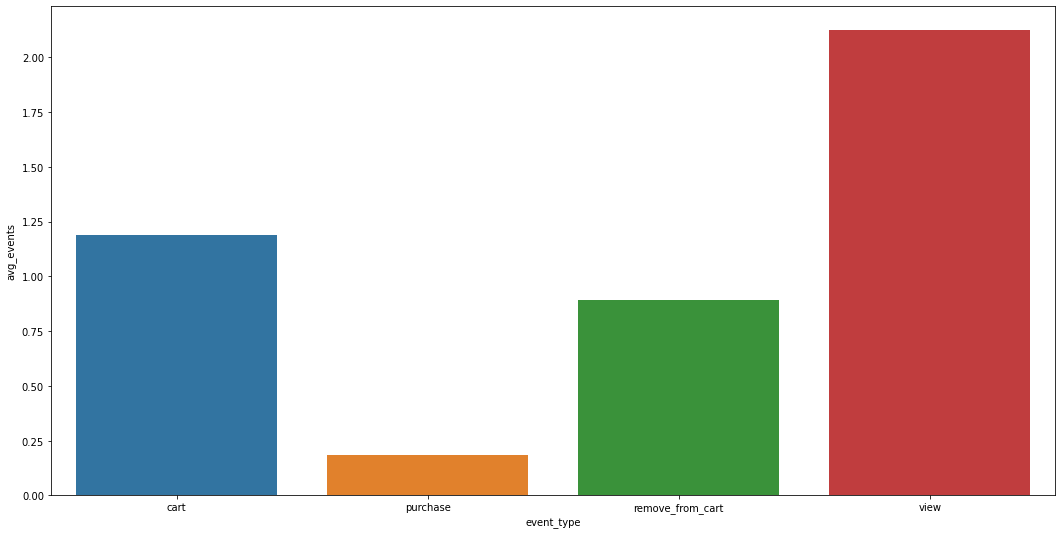

In [21]:
fig = plt.figure(figsize=(18,9))
plot = sns.barplot(x='event_type', y='avg_events', data=event_series)

#### Probability cart and bought

We want to compute the probability by evaluating $$ P=\frac{\#\text{cart}}{\#\text{cart and bought}}$$

In [51]:
cart_and_bought = df[df.event_type == 'cart']['product_id'].to_frame().merge(df[df.event_type == 'purchase'], 
                                            on = 'product_id')
cart_and_bought.drop(df[])

,product_id,event_time,event_type,category_id,category_code,brand,price,user_id,user_session
0,5802440,2020-01-01 00:06:07+00:00,purchase,2151191070908613477,NaN,NaN,2.16,595411904,74ca1cd5-5381-4ffe-b00b-a258b390db77
1,5802440,2020-01-01 06:52:17+00:00,purchase,2151191070908613477,NaN,NaN,2.16,560164151,5ed2cd64-c9f0-47c8-b3cb-b0a61ad9e7cf
2,5802440,2020-01-01 07:19:23+00:00,purchase,2151191070908613477,NaN,NaN,2.16,595349995,692ee07f-dbb2-4576-bd8b-02f3d6d27b22
3,5802440,2020-01-01 00:06:07+00:00,purchase,2151191070908613477,NaN,NaN,2.16,595411904,74ca1cd5-5381-4ffe-b00b-a258b390db77
4,5802440,2020-01-01 06:52:17+00:00,purchase,2151191070908613477,NaN,NaN,2.16,560164151,5ed2cd64-c9f0-47c8-b3cb-b0a61ad9e7cf
...,...,...,...,...,...,...,...,...,...
50059,5858222,2020-01-02 08:39:09+00:00,purchase,1487580005511725929,NaN,NaN,5.56,386491215,167a38da-d55b-48c5-8462-7e1e7bda9acc
50060,5900636,2020-01-02 08:53:59+00:00,purchase,1487580007675986893,NaN,freedecor,0.79,546292576,72755e98-a0f6-4be9-bd34-2e27f2343110
50061,5823277,2020-01-02 08:47:43+00:00,purchase,1487580012096782476,NaN,runail,3.17,587620685,92a1a0ef-08d5-48ab-8ef1-f74c4874b3cc
50062,5875557,2020-01-01 10:08:37+00:00,purchase,2084144451428549153,NaN,NaN,2.05,590617508,cbac70af-c7c8-4dfb-9060-702f0ba3e08a


In [26]:
df.groupby(["category_id","product_id"])["event_type"].count().reset_index()$


category_id          product_id
1487580004807082827  5916194        1
1487580004832248652  5706113        1
                     5706136        1
                     5706141        4
                     5706303        2
                                   ..
2235524494015856752  5898238        2
2235524499636224267  5844008        2
                     5853033        1
                     5861721       17
                     5892739        1
Name: event_type, Length: 18189, dtype: int64